## This notebook contains the data acquisition pipeline for our project

### Section 0 : imports and function definitions

In [2]:
import pandas as pd
import numpy as np
import re
import wikipedia
import datetime
import requests
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import json
import urllib
from urllib.parse import urlencode
from urllib.request import urlopen
from collections import deque
# documentation: https://mwparserfromhell.readthedocs.io/en/latest/api/mwparserfromhell.nodes.html#module-mwparserfromhell.nodes.wikilink
import mwparserfromhell
import networkx as nx
import random
from helpers import page_visits
import pickle
import os

In [3]:
%matplotlib inline

In [4]:
## data folders
data_folder = '../data/'
plots_folder = '../plots/'

In [5]:
API_URL = "https://en.wikipedia.org/w/api.php"
def parse_with_date(title, date=None):
    '''
    Function to retrieve the wikipedia article with name <title> as it was on date <date>
    :param title: title of the wikipedia article
    :param date: snapshot of the page as it was on the date. If None, scrapes the page as is now. 
    :return: the parsed page of wikipedia
    '''
    data = {"action": "query", "prop": "revisions", "rvlimit": 1,
            "rvprop": "content", "format": "json", "titles": title}
    if date is not None:
        data["rvstart"] = date
    raw = urlopen(API_URL, urlencode(data).encode()).read()
    res = json.loads(raw)
    try:
        text = list(res["query"]["pages"].values())[0]["revisions"][0]["*"]
    except KeyError as err:
        print("Key error".format(err))
        print(title)
        return None
    return mwparserfromhell.parse(text)

A heuristic we use for sampling is to give more probability to the links at the front of the page (assuming they might be more important and more related to the subject) than to the other links.

In [6]:
def sample_links(n_links, n_links_sample, percentage_l, percentage_l_subsample):
    '''
    Function to subsample links from an ordered list of links
    :param n_links: number of links a page has
    :param n_links_sample: number of links you want to sample
    :param percentage_l: consider the top percentage_l links ..
    :param percentage_l_subsample: to account for percentage_l_subsample of the subsampled links
    :return:  the chosen indices of the sampled links 
    Example call: from a list of <n_links> links, subsample <n_links_sample> links, such that the top <percentage_l>
    of the links account for <percentage_l_subsample> of the sample.
    '''
    # no sampling needed here
    if n_links_sample >= n_links:
        return np.array(range(n_links))
    
    # how many links from the first group should be subsampled
    n_links_first_group = int(n_links_sample * percentage_l_subsample)
    # how many links from the first group we have
    n_links_first_group_pop = int(n_links * percentage_l)
    
    # no sampling from the first group
    if n_links_first_group_pop < n_links_first_group:
        links_chosen_group_1 = np.array(range(n_links_first_group_pop))
        remaining = n_links_sample - n_links_first_group_pop
        links_chosen_group_2 = np.random.choice(range(n_links_first_group_pop+1, n_links), size = remaining, replace= False)
        return np.append(links_chosen_group_1, links_chosen_group_2)
    
    # if we have to sample from both groups, create the probabilities 
    perc_1 = percentage_l_subsample / n_links_first_group_pop
    perc_2 = (1 - percentage_l_subsample) / (n_links - n_links_first_group_pop)
    #print('Links from first group were sampled with p ', perc_1, ' and links from second group were sampled with p ', perc_2)
    p = [perc_1] * n_links_first_group_pop + [perc_2] * (n_links - n_links_first_group_pop)
    chosen_links = np.random.choice(n_links, size = n_links_sample, p = p, replace=False)
    return chosen_links

In [7]:
def preprocess_links(links):
    '''
    Function to convert links from wikiCode objects to string type and to filter out the non-relevant links
    '''
    non_link = re.compile('Category:|File:|wikt:|.*#.*')
    links = [str(link.title) for link in links if non_link.match(str(link.title))==None]
    links = list(set(links))
    return links

For crawling, we use the below function

In [8]:
def wiki_crawl(seed, date, max_nodes = 2701, n_links_hop1 = 150, n_links_indirect = 3, min_popularity = 30, verbose=False):
    '''
    
    :param seed: page from which crawl begins
    :param date: date at which pages are crawled
    :param max_nodes: maximum number of nodes of the resulting graph
    :param n_links_hop1: how many direct neighbours
    :param n_links_indirect: how many indirect neighbours
    :param min_popularity: the minimum number of links a page should have to be taken into the graph (to avoid stubs or really small articles)
    :param verbose: flag to enable print output
    :return: dictionary mapping nodes to list links 
    '''
    # init algo
    article_links = {}
    queue = deque([seed])

    while(len(article_links) < max_nodes):
        if len(queue) == 0:
            if verbose: print('no more links to dequeue')
            break
        article = queue.popleft()
        # crawl it
        article_content = parse_with_date(title=article, date=date)
        # check parse succesful
        if article_content is not None:
            links = article_content.filter_wikilinks()
            links = preprocess_links(links)
            # filter out the links that are 1st hop neighbors
            if seed in article_links.keys():
                links = [link for link in links if link not in article_links[seed]]
            #print(len(links))
            if (len(links) > min_popularity):
                article_links[article] = links
                if article == seed:
                    if verbose: print('Added direct', article, ' to the graph')
                    idx_chosen_links = sample_links(n_links=len(links), n_links_sample=n_links_hop1, percentage_l=0.1, percentage_l_subsample=0.5)
                else:
                    if verbose: print('Added Indirect', article, ' to the graph')
                    idx_chosen_links = sample_links(n_links=len(links), n_links_sample=n_links_indirect, percentage_l=0.2, percentage_l_subsample=0.5 )
                for idx in idx_chosen_links:
                    if links[idx] not in article_links and links[idx] not in queue:
                        queue.append(links[idx])
        if(len(article_links) % 100):
            if verbose: print('Crawled ',len(article_links), 'articles' )
    return article_links

In [9]:
def construct_graph(links):
    '''
    
    :param links: a dictionary mapping crawled articles to their links as listed on wiki page  
    :return: graph
    '''
    G = nx.DiGraph()
    G.add_nodes_from(links.keys())
    for article in G.nodes():
        for link in links[article]:
            # add link if not self-loop
            if link in links and link != article:
                G.add_edge(article, link)
    return G

In [10]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [11]:
def get_page_signal(G, start, end):
    '''
    
    :param G: graph for which we are getting the signal
    :param start: start time for getting the views (date time object)
    :param end: end time for getting the views (date time object)
    :return: a dictionary mapping nodes to views and a list of nodes for which the signal could not be obtained
    '''
    views = {}
    nodes_not_taken = []
    for node in G.nodes():
        try:
            views[node] = page_visits.getUserActivity(article=node,
                                                      granularity="daily",
                                                      start=start,
                                                      end=end,
                                                      dateformat="iso")
        except KeyError:
            nodes_not_taken.append(node)
        except json.JSONDecodeError:
            print(f'JSONDecodeError: {node}')
            nodes_not_taken.append(node)
    return views, nodes_not_taken

### Section 1: Views over time for the central articles

In [12]:
articles_w_date = [
#    ('Stan Lee', '2018-11-12'),
#    ('Stephen Hawking', '2018-03-14'),
    ('Alan Rickman', '2016-01-14')
]

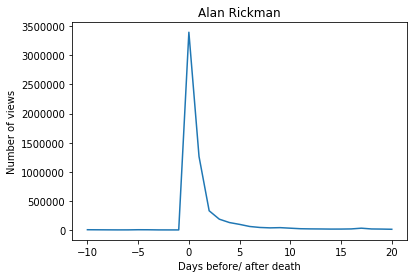

In [13]:
ndaysbefore = 10
ndaysafter = 20

for article, datestr in articles_w_date:
    date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    start = date - datetime.timedelta(days=ndaysbefore)
    end = date + datetime.timedelta(days=ndaysafter)

    outname = ''.join(c for c in article if c.isalnum())

    views = page_visits.getUserActivity(article=article,
                            granularity="daily",
                            start=start,
                            end=end,
                            dateformat="iso")
    #views_file = data_folder + '1_' + outname + '_views.pkl'
    plot_file = os.path.join(plots_folder,'1_' + outname + '.png')
    #save_object(views, views_file)

    y = [x[0] for x in views]
    x = np.arange(-ndaysbefore, ndaysafter+1)
    plt.plot(x, y)
    plt.xlabel('Days before/ after death')
    plt.ylabel('Number of views')
    plt.title(article)
    plt.savefig(plot_file)
    plt.show()


### Section 2: obtaining graphs

In [ ]:
for article, datestr in articles_w_date:
    date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    links = wiki_crawl(article, date=date)
    
    G = construct_graph(links)
    print(f'nodes: {G.number_of_nodes()} edges: {G.number_of_edges()}')

    # keep only alphanumeric characters for filesystem compatible string
    outname = ''.join(c for c in article if c.isalnum())
    graph_file = os.path.join(data_folder,'G_'+outname+'.gpickle')

    print(f'Writing {graph_file}')
    nx.write_gpickle(G, graph_file)

### Section 3: Scraping the page_view signal

In [19]:
# Site that generates JSON error
for l in list(G.nodes()):
    if 'List of films with a 100% rating on Rotten Tomatoes' in l:
        print(l)
        break

article, datestr = articles_w_date[-1]
date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
before = date - datetime.timedelta(days=ndaysbefore)
after = date + datetime.timedelta(days=ndaysafter)
try:
    views = page_visits.getUserActivity(article=l,
                                                      granularity="daily",
                                                      start=start,
                                                      end=end,
                                                      dateformat="iso")
except json.JSONDecodeError:
    print(f'JSONDecodeError: {l}')


List of films with a 100% rating on Rotten Tomatoes
JSONDecodeError: List of films with a 100% rating on Rotten Tomatoes


In [20]:
ndaysbefore = 1
ndaysafter = 0
for article, datestr in articles_w_date:
    date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    before = date - datetime.timedelta(days=ndaysbefore)
    after = date + datetime.timedelta(days=ndaysafter)

    # keep only alphanumeric characters for filesystem compatible string
    outname = ''.join(c for c in article if c.isalnum())
    graph_file = os.path.join(data_folder,'G_'+outname+'.gpickle')

    print(f'Reading {graph_file}')
    G = nx.read_gpickle(graph_file)
    signal_views_lee, nodes_not_taken = get_page_signal(G=G, start=before, end=after)

    signal_file = os.path.join(data_folder, '1_' + outname + '_signal.pkl')
    signal_not_found = os.path.join(data_folder, '1_' + outname + '_signal_not_found.pkl')
    print(f'Writing {signal_file}')
    save_object(obj = signal_views_lee, filename = signal_file)
    print(f'Writing {signal_not_found}')
    save_object(obj = nodes_not_taken, filename = signal_not_found )

Reading ../data/G_AlanRickman.gpickle
JSONDecodeError: List of films with a 100% rating on Rotten Tomatoes
Writing ../data/1_AlanRickman_signal.pkl
Writing ../data/1_AlanRickman_signal_not_found.pkl


### drafts

In [ ]:
# example calls
stan_lee_12_nov = parse_with_date(seed, date= '2018-11-13T00:00:00Z')
stan_lee_12_nov_l = stan_lee_12_nov.filter_wikilinks()

In [ ]:
# test it was saved
G2 = nx.read_gpickle(data_folder + "G_stan_lee.gpickle")

In [ ]:
# example
seed = 'Stan Lee'
start = datetime.datetime(year=2018,month=11,day=11, hour=23, minute = 59, second = 59)
end =  datetime.datetime(year=2018,month=11,day=12, hour=23, minute = 59, second = 59)
daily_view_lee = page_visits.getUserActivity(article=seed,granularity="daily",start=start,end=end,dateformat="iso")
daily_view_lee